# Probability of a Binary

In [370]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform
from scipy.optimize import newton
from scipy import stats
import corner

%matplotlib inline

### Constants

In [308]:
GGG = 6.674e-8             # Gravitational constant in cgs
alpha = -2.35              # IMF index
day_to_sec = 3600.0*24.0   # Sec in day
Rsun_to_cm = 6.995e10      # Rsun to cm
Msun_to_g = 1.989e33       # Msun to g
AU_to_cm = 1.496e13        # AU to cm
pc_to_cm = 3.086e18        # pc to cm

### Get random binary variates

In [380]:
# M1 is from power law: M^alpha
def get_M1(M_low=0.5, M_high=10.0, num_sys=1):
    C_m = 1.0 / (M_high**(alpha+1.0) - M_low**(alpha+1.0))
    tmp_y = uniform(size=num_sys)
    
    return (tmp_y/C_m + M_low**(alpha+1.0))**(1.0/(alpha+1.0))

# M2 is flat in q-space
def get_M2(M1, num_sys=1):
    return M1*uniform(size=num_sys)
    
# a is from inverse: a^-1
def get_a(a_low=1.0e4, a_high=1.0e6, num_sys=1):
    C_a = 1.0 / (np.log(a_high) - np.log(a_low))
    tmp_y = uniform(size=num_sys)
    
    return a_low*np.exp(tmp_y/C_a)

# e from thermal distribution
def get_e(num_sys=1):
    return np.sqrt(uniform(size=num_sys))

### Test random variate distributions

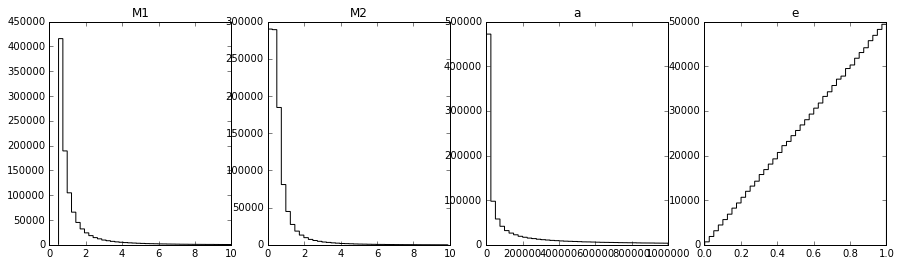

In [387]:
fig, ax = plt.subplots(1,4, figsize=(15,4))

num_sys = 1000000

M1 = get_M1(num_sys=num_sys)
M2 = get_M2(M1, num_sys=num_sys)
a = get_a(num_sys=num_sys)
e = get_e(num_sys=num_sys)

ax[0].hist(M1, histtype='step', color='k', bins=40)
ax[0].set_title('M1')
ax[1].hist(M2, histtype='step', color='k', bins=40)
ax[1].set_title('M2')
ax[2].hist(a, histtype='step', color='k', bins=40)
ax[2].set_title('a')
ax[3].hist(e, histtype='step', color='k', bins=40)
ax[3].set_title('e')

plt.show()

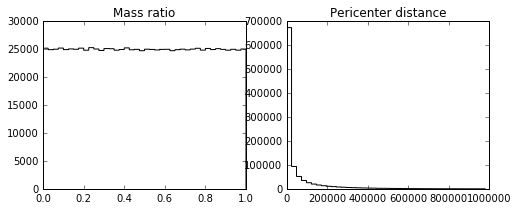

In [388]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].hist(M2/M1, histtype='step', color='k', bins=40)
ax[0].set_title('Mass ratio')

ax[1].hist(a*(1.0-e), histtype='step', color='k', bins=40)
ax[1].set_title('Pericenter distance')

plt.show()

### Get random orientation deviates

In [348]:
# Mean anomaly
def get_M(num_sys=1):
    return 2.0 * np.pi * uniform(size = num_sys)

# inclination angle
def get_inc(num_sys=1):
    return np.arccos(1.0-2.0*uniform(size = num_sys))

# argument of periapse
def get_omega(num_sys=1):
    return 2.0*np.pi*uniform(size = num_sys)

# longitude of the ascending node
def get_Omega(num_sys=1):
    return 2.0*np.pi*uniform(size = num_sys)

### Test deviates

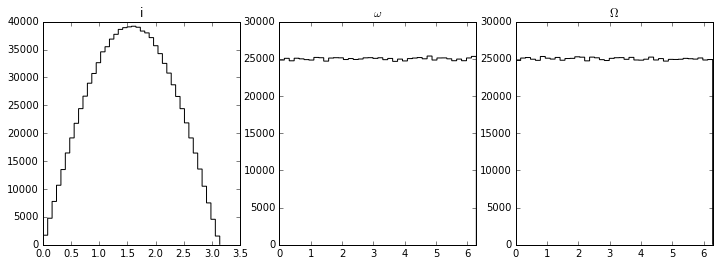

In [389]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

M = get_M(num_sys)
inc = get_inc(num_sys)
omega = get_omega(num_sys)
Omega = get_Omega(num_sys)

ax[0].hist(inc, histtype='step', color='k', bins=40)
ax[0].set_title('i')
ax[1].hist(omega, histtype='step', color='k', bins=40)
ax[1].set_title('$\omega$')
ax[1].set_xlim(0.0, 2.0*np.pi)
ax[2].hist(Omega, histtype='step', color='k', bins=40)
ax[2].set_title('$\Omega$')
ax[2].set_xlim(0.0, 2.0*np.pi)

plt.show()

### Binary functions

In [350]:
def P_to_a(M1, M2, P):
    """ Orbital period (days) to separation (Rsun) """
    mu = GGG * (M1 + M2) * Msun_to_g
    n = 2.0*np.pi / P / day_to_sec
    return np.power(mu/(n*n), 1.0/3.0) / Rsun_to_cm

def a_to_P(M1, M2, a):
    """ Orbital separation (Rsun) to period (days) """
    mu = GGG * (M1 + M2) * Msun_to_g
    n = np.sqrt(mu/(a**3 * Rsun_to_cm**3))
    return 2.0*np.pi / n / day_to_sec

In [351]:
# Function to get the true anomaly
def get_f(M, e):
    
    # Get eccentric anomaly
    def func_E(x,M,e):
        return M - x + e*np.sin(x)
    
    E = newton(func_E, 0.5, args=(M,e))

    # Get true anomaly from eccentric anomaly
    f = np.arccos((np.cos(E)-e)/(1.0-e*np.cos(E)))
    if np.sin(E) < 0:
        f = 2.0*np.pi - f            
    
    return f

In [352]:
def get_proj_sep(f, e, sep, Omega, omega, inc):
    sep_x = sep*(np.cos(Omega)*np.sin(omega+f) + np.sin(Omega)*np.cos(omega+f)*np.cos(inc))
    sep_y = sep*(np.cos(Omega)*np.cos(omega+f) - np.sin(Omega)*np.sin(omega+f)*np.cos(inc))
    proj_sep = np.sqrt(sep_x**2 + sep_y**2)

    return proj_sep


def get_pm(f, e, a, P, Omega, omega, inc):
    r_dot = a * e * np.sin(f) / np.sqrt(1.0 - e*e) * (2.0*np.pi/P)
    r_f_dot = a / np.sqrt(1.0 - e*e) * (1.0 + e*np.cos(f)) * (2.0*np.pi/P)
    pm_1 = r_dot * (np.cos(Omega)*np.cos(omega+f) - np.sin(Omega)*np.sin(omega+f)*np.cos(inc))
    pm_2 = r_f_dot * (np.cos(Omega)*np.sin(omega+f) + np.sin(Omega)*np.cos(omega+f)*np.cos(inc))
    pm = np.sqrt(pm_1**2 + pm_2**2) / 1.0e5

    return pm

### Calculate observed proper motion

In [390]:
# Calculate f's
f = np.zeros(num_sys)
for i in np.arange(num_sys):
    f[i] = get_f(M[i], e[i])
    
# Calculate separations - in Rsun
sep = a * (1.0 - e*e) / (1.0 + e*np.cos(f)) 
proj_sep = get_proj_sep(f, e, sep, Omega, omega, inc)

# Orbital period in days
P = a_to_P(M1, M2, a)
# Calculate proper motions
pm = get_pm(f, e, a*Rsun_to_cm, P*day_to_sec, Omega, omega, inc)

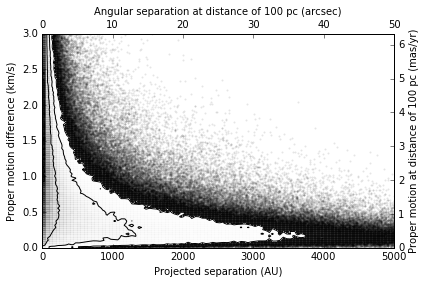

In [400]:
fig, ax1 = plt.subplots(1,1, figsize=(6,4))

xmin, xmax = 0.0, 5000.0
ymin, ymax = 0.0, 3.0

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

ax1.set_xlabel("Projected separation (AU)")
ax1.set_ylabel("Proper motion difference (km/s)")


contourf_kwargs = {'bins':100}
corner.hist2d(proj_sep*Rsun_to_cm/AU_to_cm, pm, nbins=100, range=([xmin,xmax],[ymin,ymax]), **contourf_kwargs)

ax2 = ax1.twiny()
xticks = np.linspace(xmin,xmax,6)
angles = (xticks * AU_to_cm)/(100.0 * pc_to_cm) * (180.0 * 3600.0 / np.pi)
ax2.set_xticks(angles)
ax2.set_xlabel('Angular separation at distance of 100 pc (arcsec)')


ax3 = ax1.twinx()
yticks = np.linspace(ymin, ymax, 7)
def pm_at_100pc(pm):
    return (pm * 1.0e5)/(100.0 * pc_to_cm) * (1.0e3 * 180.0 * 3600.0 / np.pi) * day_to_sec*365.25

ax3.set_ylim(0.0, pm_at_100pc(ax1.get_ylim()[1]))
ax3.set_ylabel('Proper motion at distance of 100 pc (mas/yr)')

plt.tight_layout()
plt.savefig('../figures/theta_mu.pdf', rasterized=True)

#plt.show()